# House price prediction: Advanced, code your own


In this exercise, we are going to code up our own linear regression model using 1.) least squares and 2.) gradient descent. We will apply to house price prediction using a subset of the [California house price dataset](https://www.kaggle.com/camnugent/california-housing-prices). Our dataset contains 200 observations for housing blocks in California obtained from the 1990 census. The dataset contains columns:

1. `longitude`: A measure of how far west a house is; a higher value is farther west

2. `latitude`: A measure of how far north a house is; a higher value is farther north

3. `housing_median_age`: Median age of a house within a block; a lower number is a newer building

4. `total_rooms`: Total number of rooms within a block

5. `total_bedrooms`: Total number of bedrooms within a block

6. `population`: Total number of people residing within a block

7. `households`: Total number of households, a group of people residing within a home unit, for a block

8. `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. `median_house_value`: Median house value for households within a block (measured in US Dollars)

10. `ocean_proximity`: Location of the house w.r.t ocean/sea

In this example, we are going to create a regression model to predict `median_house_value` using only `median_income`.

Load the file `housing_short.csv` and examine the first few rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("housing_short.csv")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
195,-122.22,37.77,52,391,128,520,138,1.6471,95000,NEAR BAY
196,-122.22,37.77,52,1137,301,866,259,2.5900,96400,NEAR BAY
197,-122.23,37.77,52,769,206,612,183,2.5700,72000,NEAR BAY
198,-122.23,37.78,52,472,146,415,126,2.6429,71300,NEAR BAY


In [2]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

Our goal is to predict `median_house_value`. This will be our dependent variable, $y$. Pick another variable that you think will be a useful predictor of house value, that we will use as our dependent variable, $x$. First, we should check if these variables appear correlated by plotting them.

We will pick `median_income` in this example.

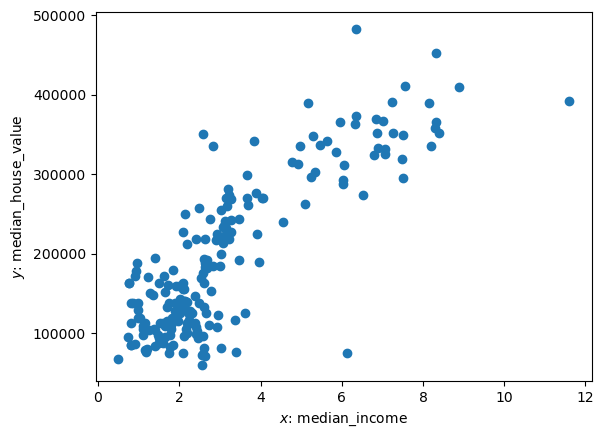

In [3]:
plt.scatter(df["median_income"], df["median_house_value"])
plt.xlabel("$x$: median_income")
plt.ylabel("$y$: median_house_value")
plt.show()

Does your choice of variable seem suitable for linear regression? 

## Linear regression
Split the dataset into a suitable training, validation and test set. 

We will use a split of 70% training, 30% validation and 20% test data. Select our training set comprising the first 140 rows of the dataset, a validation set comprising rows 141-180 and a testing set comprising rows 180-200. (Remember python indices start from 0).

In [4]:
training = df.iloc[:140, :]
validation = df.iloc[140:180, :]
testing = df.iloc[180:, :]

Create a linear regression model to predict median house value from median income using the training set. We provide code for both R and Python. You can use a package or code this from scratch. 

## From scratch solutions
This notebook includes the from scratch solutions using 
1. Least squares
2. Gradient descent 
3. Stochastic gradient descent. 

We will also compare these to the sklearn and pytorch implementations.

### Preprocessing and setup
Get $(X,y)$ arrays and normalise them.

In [5]:
# assuming that training set is a pandas dataframe
X = training["median_income"]
y = training["median_house_value"]

X = X.iloc[:, ].values.reshape(-1, 1)      # This reshapes the array so the inputs are the correct size (N, 1)
y = y.iloc[:, ].values.reshape(-1, 1)      
X.shape, y.shape

((140, 1), (140, 1))

In [6]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X)
scaler_y = StandardScaler()
scaler_y.fit(y)
X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y)


## Least squares

Our linear regression equation is
$$ y = \beta_0 + \beta_1 x_1$$
or in the matrix formulation: 
$$\mathbf{y} = \beta \mathbf{X}$$
We have $N$ data pairs of inputs and outputs, which we will index with subscript $i$, i.e., ${\mathbf{X}_i, \mathbf{y}_i}$ where $i=1, \cdots, N$. We use this linear model to make predictions for $\mathbf{y}_i$. The residual error from our linear model is the difference between a prediction and the true data, i.e., $|\mathbf{y}_i - \beta \mathbf{X_i}|$.
We want to find $\beta$ that minimises the residual sum of squares over the dataset, i.e.,
$$\arg \min_\beta \{ \sum_{i=1}^{N} (\mathbf{y}_i - \beta \mathbf{X}_i)^2 \}$$ 
We will call this term inside the curly brackets our Loss function, $L$. 

To minimise this, take the gradient with respect to $\beta$ and set it to zero
$$\frac{dL}{d\beta}= \sum_{i=1}^N (-2 \mathbf{X}_i^T \mathbf{y}_i + 2 \beta \mathbf{X}_i^T \mathbf{X}_i) = 0 $$
$$ \hat{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \cdot \mathbf{X}^T \mathbf{y} $$
This is the least squares estimate. 


Calculate $\beta$ 

In [7]:
# For the matrix formulation, add a row for the intercept
intercept = np.ones_like(X_scaled)
X_mat = np.hstack((intercept, X_scaled))
X_mat.shape

(140, 2)

In [8]:
beta = np.dot(np.linalg.inv(X_mat.T @ X_mat), (X_mat.T @ y_scaled))
beta

array([[-2.39738386e-16],
       [ 8.32224993e-01]])

In [9]:
intercept_LS = beta[0, 0]
coefficient_LS = beta[1, 0]

In [10]:
print(f"Least squares estimate: intercept {intercept_LS:.4f}, coefficient {coefficient_LS:.4f}")

Least squares estimate: intercept -0.0000, coefficient 0.8322


## Gradient descent
Instead of analytically computing the gradient, we can also use the gradient descent algorithm to estimate $\hat{\beta}$.

$$ \beta' = \beta - \alpha \nabla L $$
$\alpha$ is called the learning rate and is usually a small number. We can start with 0.01.

1. Start with a guess for $\hat{\beta}$
2. Compute $\hat{\mathbf{y}}=\hat{\beta} \mathbf{X}$. 
The mean squared error loss is $L=\frac{1}{N} \sum_{i=1}^{N}{(\hat{\mathbf{y}}_i - \mathbf{y}_i)^2}=\frac{1}{N} \sum_{i=1}^{N}{(\hat{\beta} \mathbf{X}_i - \mathbf{y}_i)^2}$
3. Compute the direction of the gradient of the loss with respect to $\beta$. This is
$$ \nabla L = \frac{1}{N} \sum_{i=1}^{N} 2(\beta \mathbf{X}^T_i \mathbf{X}_i - \mathbf{X}^T_i \mathbf{y}_i) = \frac{1}{N} 2 \mathbf{X}^T \cdot (\hat{\mathbf{y}} - \mathbf{y})$$
4. Update our estimate of $\beta$ by taking the step in the direction of reducing the gradient.
5. Repeat steps 2-4. until our estimate of $\beta$ converges.

In [15]:
N = X.shape[0]

In [16]:
alpha = 0.1
# store intercept and coefficients for plotting
intercepts = []
coefficients = []
losses = []


# initialise beta_hat randomly
beta_hat = np.random.rand(2, 1)

for t in range(100):
    y_hat = X_mat @ beta_hat 
    # compute direction of gradient
    d_L =  2*np.dot(X_mat.T, y_hat - y_scaled)/N
    
    # update
    beta_hat = beta_hat - alpha * d_L
    
    # store
    intercepts.append(beta_hat[0,0])
    coefficients.append(beta_hat[1,0])
    losses.append(np.sum((y_hat - y_scaled)**2))


    
print(beta_hat)


[[6.51226763e-11]
 [8.32224992e-01]]


Text(0.5, 1.0, 'MSE')

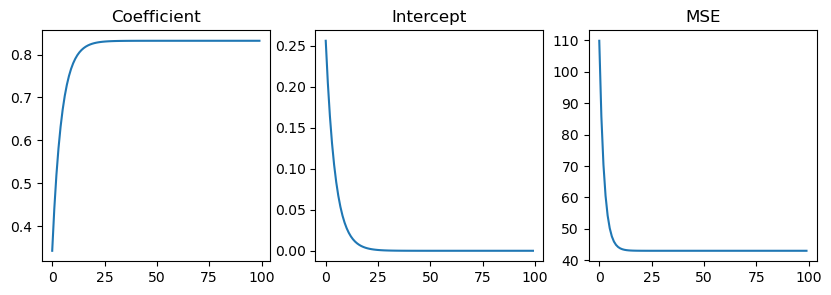

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(coefficients)
axs[0].set_title("Coefficient")

axs[1].plot(intercepts)
axs[1].set_title("Intercept")

axs[2].plot(losses)
axs[2].set_title("MSE")

Try a different values for $\alpha$. What happens?

## Stochastic gradient descent

With a relatively small dataset, we can estimate the gradient over the entire dataset. But when we have larger datasets, this becomes computationally expensive. Stochatic gradient descent is a stochastic approximation of gradient descent optimization. It replaces the true gradient calculated from the entire data set with an estimate of it, calculated from a randomly selected subset of the data.

In [18]:
X_mat.shape
batch_size = 20
N = X_mat.shape[0]
data_inds = np.arange(N)
np.random.shuffle(data_inds)
data_inds

array([ 58,  77, 119,  70,  84,  18,  79,  49,  89, 138,  36,  45,  47,
        52,  96,  44, 108,  61,   8,  73,  86, 137,  99,  22,   6,  34,
       100,   4,  91,   7, 121,  37,  68,  75,   3,   2,  81, 115,   0,
        83, 120,  24,  16, 102,  50, 104, 103,  31,  93, 122, 101,  74,
        32,  21,  46,  23,  41,  14,  28,  11,  85, 125,  88, 127, 114,
        27,  51,  55, 130,  90,  33, 128,  38, 124, 123,  39,  19, 136,
        17, 117, 113,  65,  62, 129,   5,  60,  66,  94,  98,  71,  20,
        92, 105,   9,  95, 131,   1,  29,  57,  43,  25,  82, 139, 111,
       126, 109, 118,  30,  64,  35, 133,  76,  69,  12,  13,  56,  72,
        15, 135,  87, 106,  59,  53,  10, 110, 134,  40, 112,  54, 116,
        97,  78,  42,  48, 107, 132,  63,  80,  67,  26])

In [21]:
alpha = 0.1
# store intercept and coefficients for plotting
intercepts = []
coefficients = []
losses = []


# initialise beta_hat randomly
beta_hat = np.random.rand(2, 1)

for t in range(100):
    np.random.shuffle(data_inds)
    X_shuffled = X_mat[data_inds]
    y_shuffled = y_scaled[data_inds]
    for b in range(N//batch_size):
        X_batch = X_shuffled[b*batch_size:(b+1)*batch_size]
        y_batch = y_shuffled[b*batch_size:(b+1)*batch_size]
    
        y_hat = X_batch @ beta_hat 
                
        # compute direction of gradient
        d_L =  2*np.dot(X_batch.T, y_hat - y_batch)/N
    
        # update
        beta_hat = beta_hat - alpha * d_L
    
        # store
        intercepts.append(beta_hat[0,0])
        coefficients.append(beta_hat[1,0])
        losses.append(np.sum((y_hat - y_batch)**2))


    
print(beta_hat)


[[7.61568983e-04]
 [8.33002867e-01]]


Text(0.5, 1.0, 'MSE')

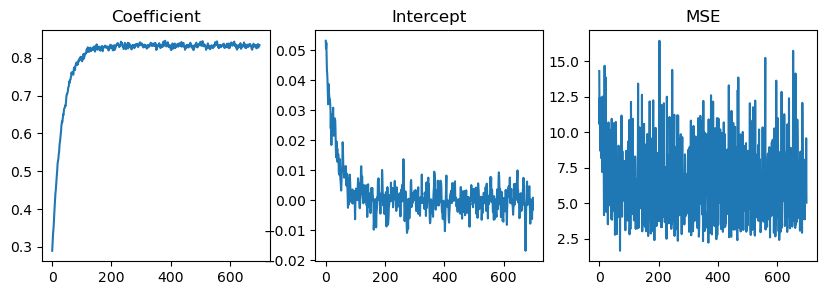

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(coefficients)
axs[0].set_title("Coefficient")

axs[1].plot(intercepts)
axs[1].set_title("Intercept")

axs[2].plot(losses)
axs[2].set_title("MSE")

### Scikit-learn solution
Compare your results to the sklearn solution `sklearn.linear_model.LinearRegression()`. See docs (link). 

In [23]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X)
scaler_y = StandardScaler()
scaler_y.fit(y)
X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y)


In [24]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_scaled, y_scaled)

# print coefficients of model
coefficient_SK = reg.coef_[0,0]
intercept_SK = reg.intercept_[0]
print(f"sklearn estimate: intercept {intercept_SK:.4f}, coefficient {coefficient_SK:.4f}")

sklearn estimate: intercept -0.0000, coefficient 0.8322


Do you get the same results?

## Pytorch solution
Can you also use a pytorch implementation of linear regression? Explore different learning rates and see how quickly your parameters converge
          


In [25]:
import torch
linear_layer = torch.nn.Linear(in_features=1, out_features=1)
optimiser = torch.optim.SGD(params = linear_layer.parameters(), lr=0.1)
loss_function = torch.nn.MSELoss()


Check parameters - there should be two: one for the coefficient/weight and one for the intercept/bias

In [26]:
for p in linear_layer.parameters():
    print(p)

Parameter containing:
tensor([[-0.9522]], requires_grad=True)
Parameter containing:
tensor([-0.8182], requires_grad=True)


In [27]:
X_torch = torch.tensor(X_scaled, dtype=torch.float32)
y_torch = torch.tensor(y_scaled, dtype=torch.float32)

In [28]:
# Store parameters for plotting 
coefficients = []
intercepts = []
losses = []
for iteration in range(100):
    optimiser.zero_grad()
    pred = linear_layer(X_torch)
    loss = loss_function(pred, y_torch)
    loss.backward()
    
    for p, param in enumerate(linear_layer.parameters()):
        if p == 0:
            coefficients.append(param.item())
        elif p==1:
            intercepts.append(param.item())
            
    losses.append(loss.item())

    # Update optimiser
    optimiser.step()


In [29]:
for p in linear_layer.parameters():
    print(p)

Parameter containing:
tensor([[0.8322]], requires_grad=True)
Parameter containing:
tensor([-1.4359e-08], requires_grad=True)


Text(0.5, 1.0, 'MSE')

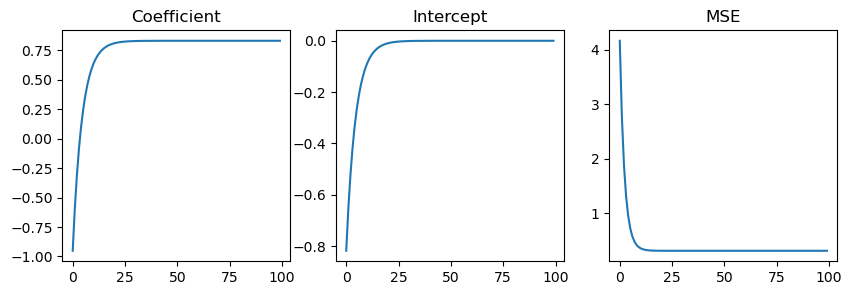

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(coefficients)
axs[0].set_title("Coefficient")

axs[1].plot(intercepts)
axs[1].set_title("Intercept")

axs[2].plot(losses)
axs[2].set_title("MSE")